In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import glob

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

#ee.Initialize()

In [3]:
#Station coordinates (FLATS around stations?)

stazioni = pd.read_csv('C:/Users/arj26323/Documents/Data/NERR data/All_stations2.csv')

# print(stazioni['Station Code'].unique())

stazioni = stazioni[stazioni['Station Code'].str.contains('nut')]

stazioni.rename(columns={"Latitude ": "Latitude", " Longitude": "Longitude"}, inplace= True)

dfs = stazioni[['Station Code', 'Station Name', 'Latitude', 'Longitude']].reset_index()

dfs

,index,Station Code,Station Name,Latitude,Longitude
0,0,acebbnut,Big Bay,32.49410,-80.32410
1,3,acefcnut,Fishing Creek,32.63593,-80.36556
2,5,acemcnut,Mosquito Creek,32.55580,-80.43800
3,8,acespnut,St. Pierre,32.52800,-80.36144
4,11,aceeinut,Edisto Island,32.50400,-80.32470
...,...,...,...,...,...
147,340,wkbwsnut,Weather Station,30.41481,-87.82600
148,344,wqbcrnut,Childs River,41.57980,-70.53090
149,347,wqbmhnut,Menauhant,41.55260,-70.54850
150,349,wqbmpnut,Metoxit Point,41.56890,-70.52160


In [4]:
dfx = dfs[dfs['Station Code']=='delslnut  '] #two spaces put in after each code for some stupid fucking reason

# dfs.iloc[0,0]

dfx

# dfx.iloc[0,3]

,index,Station Code,Station Name,Latitude,Longitude
32,68,delslnut,Scotton Landing,39.08498,-75.46058


In [5]:
px = ee.Geometry.Point([dfx.iloc[0,4], dfx.iloc[0,3]])


In [6]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

# vcr_lter = geemap.shp_to_ee('F:/Wetlands shapefiles/VCR domain/VCR_LTER_boundary.shp')

#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000)) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(px.buffer(10000))\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band)



In [7]:
ultra_col = l5_col.merge(l7_col).merge(l8_col).merge(l9_col)

# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).filterBounds(flux_ga)
ultra = ultra_col.filter(ee.Filter.calendarRange(2003, 2024,'year')).map(lambda image: image.clip(px.buffer(10000))) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

In [8]:
#Tides -- DE (is this close enough to where NERR station is? check tide gauge location)

path = r'C:/Users/arj26323/Documents/Data/Tide data/DE_tides_8537121' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])

time_mask = (df2['Time (GMT)'].dt.hour == 16)
de_time = df2[time_mask]

de_time['Verified (m)'] = de_time['Verified (m)'].replace('-', float('nan')).astype('float')

de_time

##Combine time/tide and flats data
# df_combined = pd.merge(timeseries_df, de_time, on = 'DOY')
# df_combined['Date'] = df_combined['Date_x']
# df_combined

C:\Users\arj26323\AppData\Local\Temp\ipykernel_4196\2100099468.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
C:\Users\arj26323\AppData\Local\Temp\ipykernel_4196\2100099468.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_time['Verified (m)'] = de_time['Verified (m)'].replace('-', float('nan')).astype('float')


,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY
16,2004/01/01,2024-06-21 16:00:00,0.136,-,-0.111,2004-01-01
40,2004/01/02,2024-06-21 16:00:00,0.310,-,0.387,2004-01-02
64,2004/01/03,2024-06-21 16:00:00,0.556,-,0.766,2004-01-03
88,2004/01/04,2024-06-21 16:00:00,0.820,-,1.012,2004-01-04
112,2004/01/05,2024-06-21 16:00:00,1.090,-,1.411,2004-01-05
...,...,...,...,...,...,...
192760,2003/12/27,2024-06-21 16:00:00,1.419,-,1.301,2003-12-27
192784,2003/12/28,2024-06-21 16:00:00,1.006,-,1.467,2003-12-28
192808,2003/12/29,2024-06-21 16:00:00,0.615,-,0.801,2003-12-29
192832,2003/12/30,2024-06-21 16:00:00,0.303,-,0.349,2003-12-30


In [10]:
de_time['Verified (m)'].quantile([.33, .67])

0.33    0.80600
0.67    1.59318
Name: Verified (m), dtype: float64

In [11]:
df_time = de_time

# Get the image IDs and acquisition dates separately
image_ids = ultra_col.aggregate_array('system:id').getInfo()
acquisition_dates = ultra_col.aggregate_array('system:time_start').getInfo()

# Create the DataFrame
dfx = pd.DataFrame({'Image': image_ids, 'acquisition_date': acquisition_dates})

dfx['Date'] = pd.to_datetime(dfx['acquisition_date'], unit='ms')
dfx['DOY'] = dfx['Date'].dt.strftime('%Y-%m-%d')
dfx['DOY'] = pd.to_datetime(dfx['DOY'])

df_u = pd.merge(dfx, df_time, on = 'DOY')

df_u['Verified (m)'] = df_u['Verified (m)'].replace('-', float('nan')).astype('float')

# Display the DataFrame
# print(dfx)
# print(df_u)

df_u['Verified (m)'] = df_u['Verified (m)'].replace('-', float('nan')).astype('float')

df_low = df_u[df_u['Verified (m)'] <= 0.81]
df_mid = df_u[df_u['Verified (m)'].between(0.81, 1.59)]
df_high = df_u[df_u['Verified (m)'] >= 1.59]

# print(df_high)

In [12]:
#Slope of flats, by pixel
##NOTE: buffer from NERR station changed to 1000 m from 10000; file too large otherwise

# Create a list of image names
low_names = df_low['Image'].tolist()
mid_names = df_mid['Image'].tolist()
high_names = df_high['Image'].tolist()

# Initialize separate lists
LT05_list = []
LE07_list = []
LC09_list = []
LC08_list = []
other_list = []

# Iterate through the satellite names and separate them based on keys
names = low_names

for name in names:
    if 'LT05' in name:
        LT05_list.append(name)
    elif 'LE07' in name:
        LE07_list.append(name)
    elif 'LC09' in name:
        LC09_list.append(name)
    elif 'LC08' in name:
        LC08_list.append(name)
    else:
        other_list.append(name)

col5 = ee.ImageCollection(LT05_list).map(maskL5sr).map(addFLATSL5)
col7 = ee.ImageCollection(LE07_list).map(maskL5sr).map(addFLATSL7)
col8 = ee.ImageCollection(LC08_list).map(maskL5sr).map(addFLATSL8)
col9 = ee.ImageCollection(LC09_list).map(maskL5sr).map(addFLATSL9)

col = col5.merge(col7).merge(col8).merge(col9)

# col = col.filter(ee.Filter.calendarRange(1984, 1994,'year')).filterBounds(flux_ga)

study_area = px.buffer(1000)

col = col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(px.buffer(1000))) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50)).filterBounds(study_area)

# Function to calculate linear regression for each pixel
def add_time(image):
    # Add a band representing time in years
    time = image.metadata('system:time_start').divide(31536000000)  # milliseconds to years
    return image.addBands(time.rename('time'))

colx = col.map(add_time)

# Perform linear regression for each pixel
linearFit = colx.select(['time', 'flats']).reduce(
        reducer=ee.Reducer.linearFit()
    )

In [13]:
#Directory
out_dir = os.path.join("F:/Flats imagery/NERR stations/Delaware")
##Draw geometry for exported images! It will look better

image = linearFit
filename = os.path.join(out_dir, 'low_slope.tif')

image = image.clip(px.buffer(1000)).unmask()

# geemap.ee_export_image(
#     image.select('scale'), filename=filename, scale=30, region=px.buffer(1000), file_per_band=True
# )

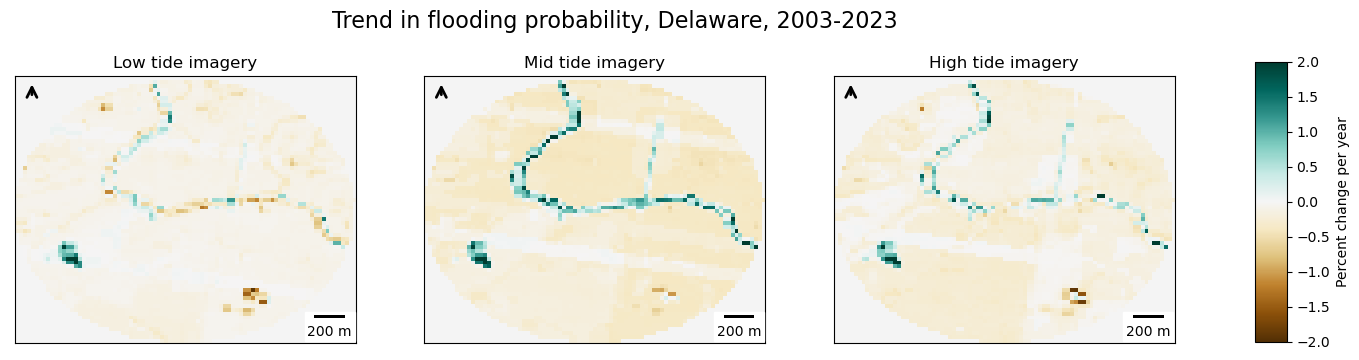

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import geopandas as gpd
from geopy.distance import great_circle
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors

h_x = "F:/Flats imagery/NERR stations/Delaware/high_slope.scale.tif"
m_x = "F:/Flats imagery/NERR stations/Delaware/mid_slope.scale.tif"
l_x = "F:/Flats imagery/NERR stations/Delaware/low_slope.scale.tif"

slope_paths = [l_x, m_x, h_x]

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title, data_min, data_max):
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        gamma = 1
        data = data ** gamma 

        # Normalize the data based on the overall min and max values - OR express as percent
        data_normalized = (data) / (1)*100
        
        cmap = 'BrBG'
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=-2, vmax=2)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)
        
        ax.annotate('', xy=(0.05, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.05, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        
        ax.set_title(title)
        
        return im

# Calculate dx for scale_bar
point1 = (31.425, -81.29)
point2 = (31.425, -80.29)
dx = great_circle(point1, point2).meters

fig, axs = plt.subplots(1, 3, figsize=(16, 4))  # Adjusted figsize

ims = []
titles = ['Low tide imagery', 'Mid tide imagery', 'High tide imagery']
data_min = float('inf')
data_max = float('-inf')

for i, ax in enumerate(axs.flat):
    with rasterio.open(slope_paths[i]) as src:
        data = src.read(1)
        data_min = min(data_min, np.min(data))
        data_max = max(data_max, np.max(data))

for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(slope_paths[i], ax, titles[i], data_min, data_max)
    ims.append(im)

plt.suptitle('Trend in flooding probability, Delaware, 2003-2023', fontsize=16)

fig.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.85)

# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = plt.colorbar(ims[-1], cax=cbar_ax, label='Percent change per year')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('allsap_trend.png',bbox_inches='tight', dpi = 300)

plt.show()


In [ ]:
Map = geemap.Map(center=[39009,-79.46], zoom=15)

Map.addLayer(l5_col.first(), {'bands': ['SR_B4',  'SR_B3',  'SR_B2'], 'min': 0, 'max': 0.3}, 'Landsat 5')
Map.addLayer(l8_col.first(), {'bands': ['SR_B5',  'SR_B4',  'SR_B3'], 'min': 0, 'max': 0.2}, 'Landsat 8')

Map.addLayer(px, {}, 'NERR station')
Map

In [ ]:
'''
Might be something here after all? It looks like there is an increase in flooding in the tidal creek and 
around the edges from 2003-2023; only a 20 year period, because that's about as far back as I can get
tide data at this station (2002 actually is the first year, it seems - though the NOAA site says the station
was established in 1997)
'''